#### n the South Pacific.

Importation of appropriate packages

In [1]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

try:
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

    LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
    LAT_FORMAT = LatitudeFormatter(degree_symbol="")
except ModuleNotFoundError:
    print("Cartopy is not installed. Figure will not be produced.")

warnings.filterwarnings("ignore")


from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config
from cloudbandpy.misc import compute_resolution, wrapTo180
from cloudbandpy.io_utilities import load_data_from_saved_var_files, load_ymlfile
from cloudbandpy.figure_tools import set_fontsize

Load configuration files

In [2]:
# Load configuration file
config_file = os.path.join("../config", "config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
# update configuration for this study
config["parameters_file"] = os.path.join("../parameters", "parameters_southhemisphere.yml")
config["clouddata_path"] = os.path.join("../data")
# deactivate tracking for efficiency
config["run_inheritance_tracking"] = False
config["saved_dirpath"] = os.path.join("../data")
config["startdate"] = "19790110.00"
config["enddate"] = "19790118.00"
config["load_saved_files"] = True
add_startend_datetime2config(config)
listofdates = create_list_of_dates(config)
parameters = load_ymlfile(config["parameters_file"])

2023-05-11 10:16:36,182 - io_utilities.load_ymlfile - INFO: Configuration file loaded
2023-05-11 10:16:36,184 - io_utilities.load_ymlfile - INFO: Parameters file loaded


Setting up domain like Huang and Vincent (1983)

In [3]:
config["lon_west"] = 170
config["lon_east"] = 250
config["lat_north"] = 10
config["lat_south"] = -50
# Create longitudes and latitudes for the specific region
resolution_era5 = 0.5  # degree
lons_globe = np.arange(0, 360, 0.5)
lats = np.arange(config["lat_north"], config["lat_south"] - resolution_era5, -resolution_era5)
lons = np.arange(config["lon_west"], config["lon_east"] + resolution_era5, resolution_era5)
resolution = compute_resolution(lons, lats)
# Load parameters directly from directory
parameters = load_ymlfile(config["parameters_file"])

2023-05-11 10:16:36,209 - io_utilities.load_ymlfile - INFO: Parameters file loaded


Load data and detect cloud bands from this specific event

In [4]:
# Load OLR data from the first part of this specific event from the saved .npy data
olr1018jan1979 = load_data_from_saved_var_files(config, varname="daily_variable")

(_, _, _, _, _, list_of_cloud_bands1018jan1979) = detection_workflow(
            var2process=olr1018jan1979,
            parameters=parameters,
            latitudes=lats,
            longitudes=lons,
            resolution=resolution,
            listofdates=listofdates,
            config=config,
        )
print("Number of cloud bands per day:")
for iday, el in enumerate(list_of_cloud_bands1018jan1979):
    print(f"Day {iday}: {len(el)} cloud band(s)")

# Average cloud band arrays to match Figure 1 (top) from Huand and Vincent (1983).
# There is one cloud band per day, so we simplify.
mean_cloudbands1018jan1979 = np.mean([el[0].cloud_band_array for el in list_of_cloud_bands1018jan1979], axis=0)

2023-05-11 10:16:36,225 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 19790110.00 to 19790118.00
2023-05-11 10:16:36,228 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-05-11 10:16:36,245 - cb_detection.detection_workflow - INFO: Cloud band detection done


Number of cloud bands per day:
Day 0: 1 cloud band(s)
Day 1: 1 cloud band(s)
Day 2: 1 cloud band(s)
Day 3: 1 cloud band(s)
Day 4: 1 cloud band(s)
Day 5: 1 cloud band(s)
Day 6: 1 cloud band(s)
Day 7: 1 cloud band(s)
Day 8: 1 cloud band(s)


Create a map of the mean of cloud bands

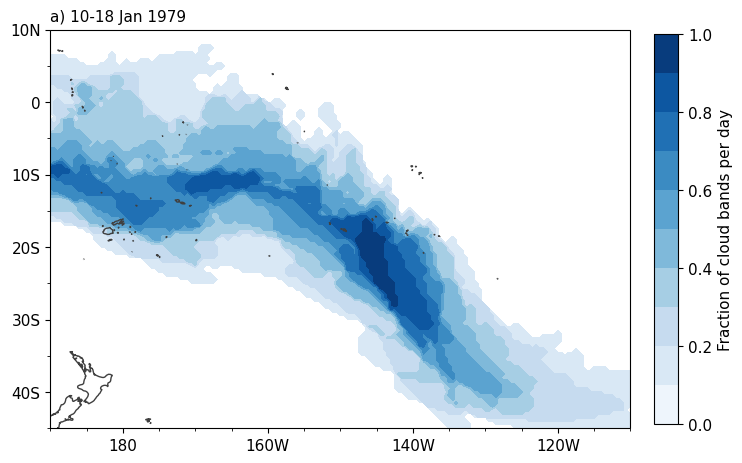

In [5]:
lat_north, lat_south = 10, -45
lonticks = np.concatenate((np.arange(0, 180, 20), np.arange(-180, 0, 20)))
latticks = np.arange(-50, 20, 10)

set_fontsize()

fig, ax = plt.subplots(
    1, 1, figsize=(8, 6), sharey=True,
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
fill = ax.contourf(
    lons,
    lats,
    np.ma.masked_where(mean_cloudbands1018jan1979 == 0, mean_cloudbands1018jan1979),
    transform=ccrs.PlateCarree(),
    levels = np.arange(0, 1.1, .1),
    cmap="Blues"
)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set_xticks(lonticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LON_FORMAT)
ax.yaxis.set_major_formatter(LAT_FORMAT)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])
ax.set_title(f"a) 10-18 Jan 1979", loc="left", fontsize=11)



fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.17, 0.03, 0.65])
cbar = fig.colorbar(fill, cax=cbar_ax)
cbar.set_label("Fraction of cloud bands per day")

plt.show()